In [1]:
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import evaltools as et, viz_tools
import cmocean as cmo
import datetime as dt
import netCDF4 as nc
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import cmocean
import f90nml
import os
import pickle

%matplotlib inline

In [2]:
# path to model files:
PATH= '/results/SalishSea/nowcast-green.201812/'

# start and end dates for analysis:
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2019,6,1)

# number of days per model file:
flen=1

# dictionary mapping desired model variables to the file types where they are found
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T',
         'flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}

# dictionary mapping model file types to their time resolution in hours (1 is hourly files, 24 is daily)
fdict={'ptrc_T':1,'grid_T':1}

# results format
# -- nowcast: files like 01jan15/SalishSea_1h_20150101_20150101_ptrc_T.nc
# -- long: files like SalishSea_1h_20150206_20150804_ptrc_T_20150427-20150506.nc, all in one directory
namfmt='nowcast'

# path to directory containing database: 
# obsDir='/ocean/shared/SalishSeaCastData/DFO/BOT/' #normal obs dir
obsDir='/data/eolson/MEOPAR/OBS/'            #temporary obs dir
#(dbname defaults to 'DFO_OcProfDB.sqlite')

# Where to store last pickle file:
pkldir='/data/eolson/results/MEOPAR/clusterGroups/'

### 1) load DFO data and match it to model output: don't repeat this part unless you want to look at different years (outside 2013-2016)

In [3]:
# load DFO bottle data (returns pandas dataframe)
# AbsSal is Absolute (actually reference) Salinity, and ConsT is Conservative Temperature
# N is nitrate+nitrate, Si is Silicate; Chlorophyll_Extracted; Z is depth (m); dtUTC is datetime in UTC
# excludeSaanich=True -> do not include data from Saanich Inlet
df1=et.loadDFO(basedir=obsDir,datelims=(start_date,end_date),excludeSaanich=True,)
print(len(df1))
df1.head()

7153


,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC
0,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,1.9,NaN,None,None,NaN,mg/m^3,15.31,32.14,umol/L,29.227507,9.859421,1.883998,2015-02-11 11:04:07
1,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,6.6,NaN,None,None,2.57,mg/m^3,17.13,33.90,umol/L,29.484341,9.777243,6.544340,2015-02-11 11:04:07
2,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,6.7,NaN,None,None,NaN,mg/m^3,NaN,NaN,umol/L,29.484839,9.771987,6.643495,2015-02-11 11:04:07
3,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,11.0,NaN,None,None,NaN,mg/m^3,NaN,NaN,umol/L,30.144549,9.439995,10.907117,2015-02-11 11:04:07
4,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,11.0,NaN,None,None,NaN,mg/m^3,20.62,37.65,umol/L,30.157913,9.433733,10.907117,2015-02-11 11:04:07


In [4]:
# match model output to observations and return both in a dataframe
# the model variables will have their original names prefixed by mod_, eg mod_vosaline
# the observation file names are unchanged. 
data=et.matchData(data=df1,filemap=filemap, fdict=fdict, mod_start=start_date, mod_end=end_date, 
                  mod_nam_fmt=namfmt, mod_basedir=PATH, mod_flen=flen,
                  meshPath='/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')

(Lat,Lon)= 49.011 -125.17033333333333  not matched to domain
(Lat,Lon)= 49.02133333333333 -125.15683333333334  not matched to domain
(Lat,Lon)= 49.0305 -125.15283333333333  not matched to domain
(Lat,Lon)= 49.0415 -125.15133333333333  not matched to domain
(Lat,Lon)= 49.0425 -125.151  not matched to domain
(Lat,Lon)= 49.05233333333333 -125.143  not matched to domain
(Lat,Lon)= 49.070166666666665 -125.15616666666666  not matched to domain
(Lat,Lon)= 49.071333333333335 -125.15733333333333  not matched to domain
(Lat,Lon)= 49.083 -125.17166666666667  not matched to domain
(Lat,Lon)= 49.09283333333333 -125.19416666666666  not matched to domain
(Lat,Lon)= 49.295 -123.05466666666666  not matched to domain
(Lat,Lon)= 49.29516666666667 -123.05383333333333  not matched to domain
(Lat,Lon)= 49.29516666666667 -123.03316666666667  not matched to domain
(Lat,Lon)= 49.29533333333333 -123.0555  not matched to domain
(Lat,Lon)= 49.29783333333334 -122.98066666666666  not matched to domain
(Lat,Lon)= 49

In [5]:
#Chl:N ratio used later in plots; get value from namelist associated with model output
mod_chl_N=et.getChlNRatio(basedir=PATH,nam_fmt='nowcast')
print(mod_chl_N)

1.5


/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


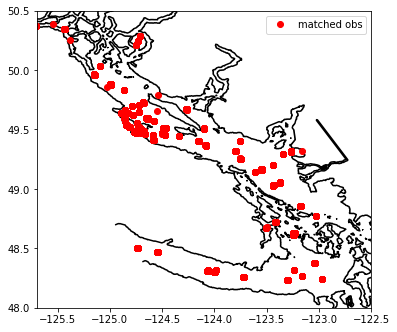

In [6]:
# plot matched data locations
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='matched obs')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

In [7]:
# add column for day of year
data['YD']=et.datetimeToYD(data['dtUTC'])

In [8]:
data.dropna(axis=1,how='all',inplace=True)

In [9]:
def logt(x):
    return np.log10(x+.001)

In [10]:
# chlorophyll calculations
data['l10_obsChl']=logt(data['Chlorophyll_Extracted'])
data['l10_modChl']=logt(mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates']))
data['mod_Chl']=mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])
data['Chl']=data['Chlorophyll_Extracted']

### 2) add Cluster info: Also don't need to repeat this unless you want other years

In [11]:
clusterD='/data/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pkls/'
cxf='Xcoords_for571_stations.pkl'
cyf='Ycoords_for571_stations.pkl'
cfile='BIO_clno_5_2015_reass.pkl' # only 2015 and 2016 overlap with hplc
cver='BIO'

In [12]:
data['Year']=[ii.year for ii in data['dtUTC']]

In [13]:
cx=pickle.load(open(clusterD+cxf, 'rb'))
cy=pickle.load(open(clusterD+cyf, 'rb'))
cf=dict()
for iyear in np.unique(data.Year):
    cf[iyear]=pickle.load(open(clusterD+cfile,'rb'))

In [14]:
def round2(num):
    return int(np.trunc((num+2)/10)*10+2)

In [15]:
data['Cluster']=np.zeros(len(data))

In [16]:
for ir, row in data.iterrows():
    ii=(cx==round2(row['i']))&(cy==round2(row['j']))
    if sum(ii)==1:
        cluster=cf[row['Year']][ii]
        data.at[ir,'Cluster']=int(cluster)

In [17]:
# number of points not assigned a cluster, total length of dataframe:
np.sum(data['Cluster']==0),len(data)

(930, 6877)

In [18]:
pickle.dump(data,open(os.path.join(pkldir,'DFODataModelClusterBIO_1812temp.pkl'),'wb'))

# Jump to here to load pandas dataframe containing DFO Obs, model values, and Cluster ID

In [19]:
data.keys()

Index(['Year', 'Month', 'Day', 'Hour', 'Lat', 'Lon', 'Pressure', 'Depth',
       'Chlorophyll_Extracted', 'Chlorophyll_Extracted_units', 'N', 'Si',
       'Silicate_units', 'AbsSal', 'ConsT', 'Z', 'dtUTC', 'j', 'i',
       'mod_nitrate', 'mod_silicon', 'mod_ammonium', 'mod_diatoms',
       'mod_ciliates', 'mod_flagellates', 'mod_vosaline', 'mod_votemper', 'k',
       'YD', 'l10_obsChl', 'l10_modChl', 'mod_Chl', 'Chl', 'Cluster'],
      dtype='object')

In [20]:
# create dictionary of dataframe views by year
datyr=dict()
yy=np.array([ii.year for ii in data['dtUTC']])
yys=np.unique(yy)
for yr in yys:
    datyr[yr]=data.loc[yy==yr]

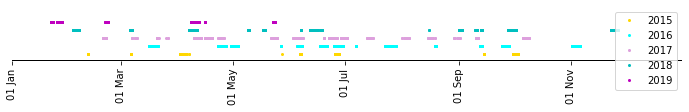

In [21]:
# plot matched data sampling times
clist=('gold','aqua','plum','c','m','r','g','b','brown','gray')
fig,axL=plt.subplots(1,1,figsize=(12,1))
for ii, yr in enumerate(yys):
    dshift=dt.datetime(yys[0],1,1)-dt.datetime(yr,1,1)
    axL.plot(datyr[yr].dtUTC+dshift,np.zeros(np.shape(datyr[yr].dtUTC))+.1*ii,'.',
             color=clist[ii],markersize=4,label=str(yr))
axL.set_yticks(());
yearsFmt = mdates.DateFormatter('%d %b')
axL.xaxis.set_major_formatter(yearsFmt)
axL.xaxis.set_ticks([dt.datetime(int(yys[0]),1,1), dt.datetime(int(yys[0]),3,1),dt.datetime(int(yys[0]),5,1),dt.datetime(int(yys[0]),7,1),
                     dt.datetime(int(yys[0]),9,1),dt.datetime(int(yys[0]),11,1),dt.datetime(int(yys[0])+1,1,1)])
for tick in axL.get_xticklabels():
        tick.set_rotation(90)
        tick.set_horizontalalignment('center')
axL.set_ylim(-.1,.1*(len(datyr.keys())+1))
axL.set_xlim(dt.datetime(yys[0],1,1),dt.datetime(yys[0],12,31))
axL.legend()
axL.set_frame_on(False)
xmin, xmax = axL.get_xaxis().get_view_interval()
ymin, ymax = axL.get_yaxis().get_view_interval()
axL.add_artist(mpl.lines.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

#### Display stats

In [22]:
print('Chl depth<15:') 
et.printstats(data.loc[data.Z<15,:],'Chl','mod_Chl')
for icl in range(0,6):
    print('cluster',icl)
    et.printstats(data.loc[data.Cluster==icl,:],'Chl','mod_Chl')

Chl depth<15:
  N: 1128
  bias: -0.15767933075767626
  RMSE: 3.911623393134565
  WSS: 0.5323427883518072
cluster 0
  N: 128
  bias: -0.1435524833914541
  RMSE: 3.29517076644243
  WSS: 0.55275424495332
cluster 1
  N: 100
  bias: -0.19800167261920887
  RMSE: 2.104125417993891
  WSS: 0.6599571843937044
cluster 2
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan
cluster 3
  N: 884
  bias: -0.13103394551955727
  RMSE: 3.3801471706772204
  WSS: 0.563330526469132
cluster 4
  N: 237
  bias: 0.13045227886614308
  RMSE: 3.1385588622564744
  WSS: 0.48196240554005354
cluster 5
  N: 298
  bias: 0.029437413179504546
  RMSE: 3.749270836356915
  WSS: 0.6264815246228495


/home/eolson/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/eolson/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  RMSE=np.sqrt(np.sum((mod-obs)**2)/N)
/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1114: RuntimeWarning: invalid value encountered in double_scalars
  WSS=1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-obsmean)+np.abs(obs-obsmean))**2)


### mod vs. obs plots

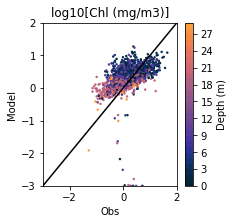

In [23]:
cm1=cmocean.cm.thermal
bounds = np.array(np.arange(0,30))
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=200)
#pcm = ax[1].pcolormesh(X, Y, Z1, norm=norm, cmap='RdBu_r')
fig,ax=plt.subplots(1,1,figsize=(3,3))
args={'marker':'.','s':8,'norm':norm}
ps=et.varvarScatter(ax,data,'l10_obsChl','l10_modChl','Z',cm=cm1,args=args)
cb=fig.colorbar(ps,ax=ax,boundaries=np.arange(0,30))
cb.set_label('Depth (m)')
ax.set_ylabel('Model')
ax.set_xlabel('Obs')
ax.set_title('log10[Chl (mg/m3)]')
ax.set_xlim(-3,2)
ax.set_ylim(-3,2)
ax.plot((-3,2),(-3,2),'k-')


/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


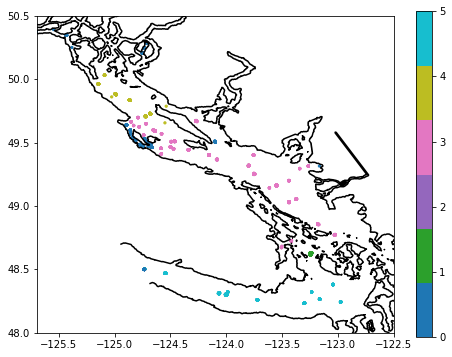

In [24]:
### map clusters
fig, ax = plt.subplots(figsize = (8,6))
viz_tools.set_aspect(ax, coords = 'map')
m=ax.scatter(data['Lon'], data['Lat'],c=data['Cluster'],s=5,cmap=plt.get_cmap('tab10',6))
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
plt.colorbar(m)
ax.set_ylim(48, 50.5)
ax.set_xlim(-125.7, -122.5);

In [25]:
## Plot residuals by year day for each cluster

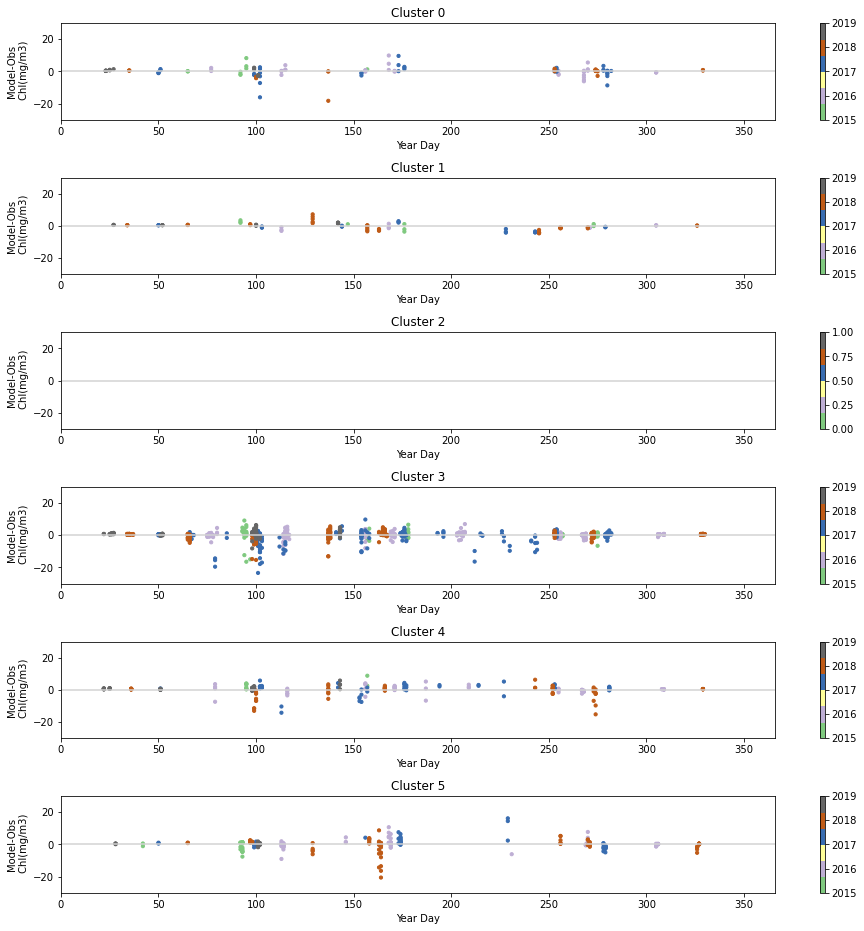

In [38]:
fig,ax=plt.subplots(6,1,figsize=(16,16))
fig.subplots_adjust(hspace=.6)
for icl in range(0,6):
    icld=data.loc[data.Cluster==icl]
    ix=ax[icl]
    m=ix.scatter(icld['YD'],icld['mod_Chl']-icld['Chl'],c=icld['Year'],s=10,cmap=plt.get_cmap('Accent',6))
    ix.set_xlabel('Year Day')
    ix.set_ylabel('Model-Obs\n Chl(mg/m3)')
    ix.set_xlim(0,366)
    ix.set_ylim(-30,30)
    ix.set_title(f'Cluster {icl}')
    fig.colorbar(m,ax=ix)
    ix.plot((0,366),(0,0),'-',color='lightgray')

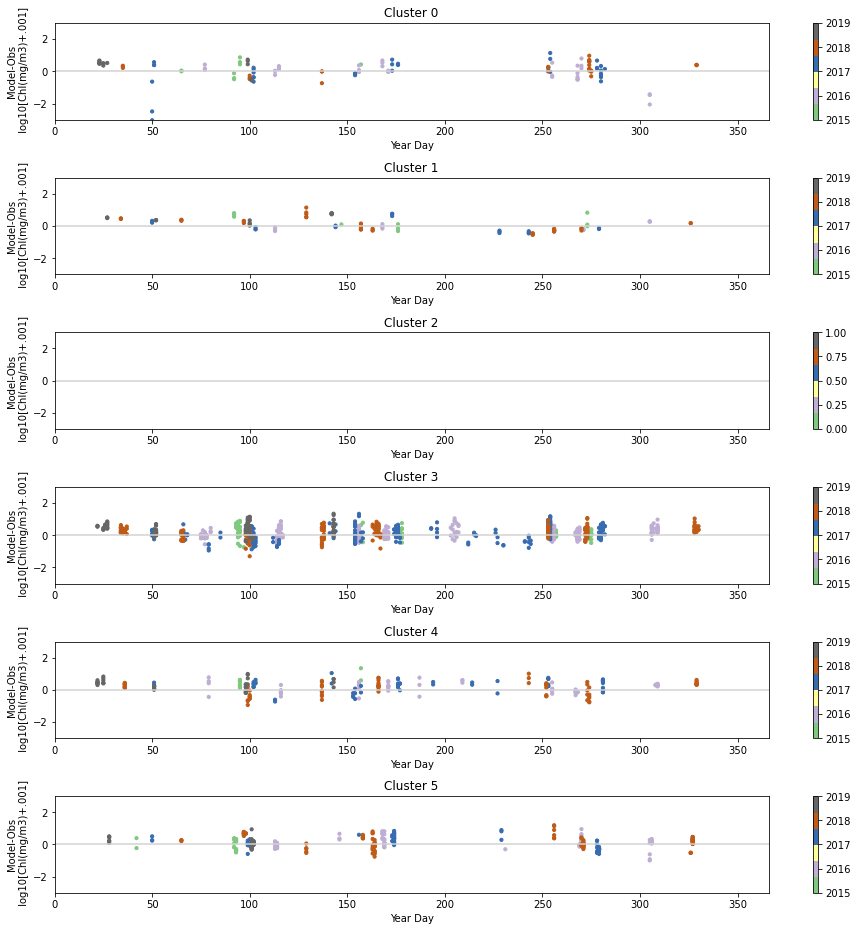

In [37]:
fig,ax=plt.subplots(6,1,figsize=(16,16))
fig.subplots_adjust(hspace=.6)
for icl in range(0,6):
    icld=data.loc[data.Cluster==icl]
    ix=ax[icl]
    m=ix.scatter(icld['YD'],icld['l10_modChl']-icld['l10_obsChl'],c=icld['Year'],s=10,cmap=plt.get_cmap('Accent',6))
    ix.plot((0,366),(0,0),'-',color='lightgray')
    ix.set_xlabel('Year Day')
    ix.set_ylabel('Model-Obs\n log10[Chl(mg/m3)+.001]')
    ix.set_xlim(0,366)
    ix.set_ylim(-3,3)
    ix.set_title(f'Cluster {icl}')
    fig.colorbar(m,ax=ix)